In [ ]:
#https://github.com/sandgate-dev/coding-practice/blob/master/coding/ml-dl/tensorfow/untitled-2/implementation-of-a-cnn-fire-module-for-squeezenet.md

#referencia do codigo:
#https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/untitled-2/train-and-evaluate-squeezenet-on-cifar10-dataset

In [1]:
#importando bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#carregando dados necessários em variáveis pra facilitar o uso
datasets = tf.keras.datasets
layers = tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
optimizers = tf.keras.optimizers
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image
utils = tf.keras.utils
callbacks = tf.keras.callbacks

In [ ]:
#carregando o MNIST em variáveis de treino e de teste
#essas variáveis contém vetores de dados
#dados baixados direto do tensowflow
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

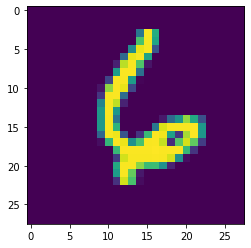

In [ ]:
#Sample de imagens do MNIST - printa uma imagem do MNIST
plt.figure()
plt.imshow(x_train[59000,:,:])
plt.show()

In [ ]:
#expande as dimensões do dataset
#essas funções são utilizadas para que se encaixem na entrada da squeezenet
#dados de treino
x_train = np.expand_dims(x_train, axis=-1)
print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
#expande as dimensões do dataset
#essas funções são utilizadas para que se encaixem na entrada da squeezenet
#dados de teste
x_test = np.expand_dims(x_test, axis=-1)
print(x_test.shape)

(10000, 28, 28, 1)


In [ ]:
#gera batches de imagens do MNIST com o aumento de dados em tempo real
#apenas dados de treino
train_datagen = preprocessing_image.ImageDataGenerator(
      #fator para reescala das imagens. Multiplica as imagens pelo fator informado.
      #Nesse caso transforma todas as imagens em um fator de 0 a 255
      #nomalização de dados
      rescale=1./255,
      #intensidade de cisalhamento (ângulo de cisalhamento no sentido anti-horário em graus)
      shear_range=0.1,
      #alcance para zoom aleatório
      zoom_range=0.1,
      #rotaciona as entradas na horizontal de forma aleatória
      horizontal_flip=True)

#gera batches de imagens do MNIST com o aumento de dados em tempo real
#realiza o reescalamento das imagens
#apenas dados de teste
test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [ ]:
#transforma vetores de classes (nomes de classes que são inteiros) para uma
#matriz de classes binária
#One Hot Encoding
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)

In [ ]:
#criando o generator de treino e teste
train_generator = train_datagen.flow(x=x_train, y=y_train, batch_size=32, shuffle=True)
test_generator = trainá-lo_datagen.flow(x=x_test, y=y_test, batch_size=32, shuffle=True)

In [ ]:
#As próximas funções irão recriar o modelo da squeezenet proposta do Iandola et. al
#esse modelo foi criado em https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/untitled-2/train-and-evaluate-squeezenet-on-cifar10-dataset

In [3]:
#SQUEEZENET MODEL

#fire module
#módulo que expande e reduz as camadas da rede, esse é o diferencial da squeezenet e o
#que faz ela ser uma rede pequena
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    #compressão de camadas com convoluções 1x1, seguida de aplicações da ReLU
    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    #expansão de camadas com convoluções 1x1
    #essa parte recebe a camada processada comprimida
    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    #expansão de camadas com convoluções 3x3
    #essa parte recebe a camada processada comprimida
    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    #concatenação da camada processada pela direita e pela esquerda
    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')

    #retorna a camada com a compressão e duas expansões
    return x

#modelo da squeezenet é feito na função SqueezeNet
def SqueezeNet(input_shape=(28,28,1), classes=10):

    img_input = layers.Input(shape=input_shape)

    #primeira camada convolucional
    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
    #x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    #utilização do fire module
    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.5, name='drop9')(x)

    #segunda camada convolucional
    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)

    #criando o modelo da squeezenet
    model = models.Model(img_input, out, name='squeezenet')

    #retornando o modelo
    return model

In [ ]:
#função para compilar o modelo
def compile_model(model):

    #erro
    loss = losses.categorical_crossentropy

    #otimizador
    optimizer = optimizers.RMSprop(learning_rate=0.001)

    #métrica utilizada
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]

    #compile model with loss, optimizer, and evaluation metrics
    #compilação do modelo
    model.compile(optimizer, loss, metric)

    #retornando o modelo compilado
    return model

In [4]:
model = SqueezeNet()
model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 13, 13, 64)           640       ['input_1[0][0]']             
                                                                                                  
 relu_conv1 (Activation)     (None, 13, 13, 64)           0         ['conv1[0][0]']               
                                                                                                  
 fire2/squeeze1x1 (Conv2D)   (None, 13, 13, 16)           1040      ['relu_conv1[0][0]']          
                                                                                         

In [ ]:
#criando o modelo e o compilando (chamando as funções para tal)
model = SqueezeNet()
model = compile_model(model)

In [ ]:
#treinando o modelo
epoch = 50      #quantidade de épocas
history = model.fit_generator(
    train_generator,
    steps_per_epoch=400,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=200)

Epoch 1/50


<ipython-input-61-e2003aa57673>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


400/400 [==============================] - 11s 24ms/step - loss: 1.5970 - categorical_accuracy: 0.4237 - top_k_categorical_accuracy: 0.8180 - val_loss: 0.9613 - val_categorical_accuracy: 0.6781 - val_top_k_categorical_accuracy: 0.9686
Epoch 2/50
400/400 [==============================] - 12s 29ms/step - loss: 0.6917 - categorical_accuracy: 0.7720 - top_k_categorical_accuracy: 0.9832 - val_loss: 0.4948 - val_categorical_accuracy: 0.8308 - val_top_k_categorical_accuracy: 0.9922
Epoch 3/50
400/400 [==============================] - 10s 24ms/step - loss: 0.4694 - categorical_accuracy: 0.8448 - top_k_categorical_accuracy: 0.9901 - val_loss: 0.3000 - val_categorical_accuracy: 0.8989 - val_top_k_categorical_accuracy: 0.9972
Epoch 4/50
400/400 [==============================] - 9s 23ms/step - loss: 0.3297 - categorical_accuracy: 0.8983 - top_k_categorical_accuracy: 0.9942 - val_loss: 0.2403 - val_categorical_accuracy: 0.9212 - val_top_k_categorical_accuracy: 0.9967
Epoch 5/50
400/400 [========

In [ ]:
#função para plotar os gráficos de erro e acurácia do modelo
#faz uma relação entre o que foi treinado e o teste do modelo com os samples do mnist
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Acurácia - SqueezeNet')
    plt.grid()
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.xticks([0,5,10,15,20,25,30,35,40,45])
    plt.legend(['Treino', 'Validação'], loc='lower right')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Custo - SqueezeNet')
    plt.ylabel('Custo')
    plt.xlabel('Épocas')
    plt.xticks([0,5,10,15,20,25,30,35,40,45])
    plt.legend(['Treino', 'Validação'], loc='upper right')
    plt.grid()

    plt.show()

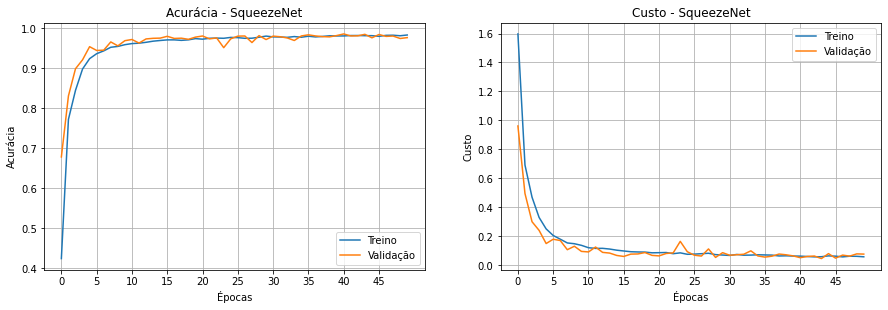

In [ ]:
#plota o gráfico chamando a função
plot_accuracy_and_loss(history)

In [ ]:
#armazena o tempo total da época em str
total_epoch = str(epoch)

In [ ]:
#avalia o modelo e printa a acurácia
acc = model.evaluate(x_test, y_test, verbose=1)
print(acc)

313/313 [==============================] - 1s 4ms/step - loss: 58.6250 - categorical_accuracy: 0.8547 - top_k_categorical_accuracy: 1.0000
[58.62502670288086, 0.8547000288963318, 1.0]


In [ ]:
# #salva o modelo no formato pb
# model.save('content/drive/MyDrive/Sistema-Reconhecimento-Caracteres-Kamilla/Algoritmos Colab/Squeezenet/model_squeeze/modelo'+ total_epoch)

# #salva o modelo no formado .h5
model.save('saved_model/model_squeeze_50.h5')

#model.save('content/drive/MyDrive/Sistema-Reconhecimento-Caracteres-Kamilla/Algoritmos Colab/Squeezenet/model_squeeze/model_squeeze_50')

In [ ]:
#converte o modelo para o formato .tflite
converter = tf.lite.TFLiteConverter.from_saved_model('content/drive/MyDrive/Sistema-Reconhecimento-Caracteres-Kamilla/Algoritmos Colab/Squeezenet/model_squeeze/model_squeeze_50') # path to the SavedModel directory

#converter.experimental_new_converter = True
tflite_model = converter.convert()

#salva o modelo em memória.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)